In [2]:
# Nhập thư viện 
import pandas as pd
import math
import numpy as np
import graphviz
import matplotlib.pyplot as plt

In [3]:
# dataset = pd.read_csv('./data.csv')

dataset = pd.DataFrame({
    'outlook': ['sunny', 'sunny', 'overcast', 'rain', 'rain', 'rain', 'overcast', 'sunny', 'sunny', 'rain', 'sunny', 'overcast', 'overcast', 'rain'],
    'temperature': ['hot', 'hot', 'hot', 'mild', 'cool', 'cool', 'cool', 'mild', 'cool', 'mild', 'mild', 'mild', 'hot', 'mild'],
    'humidity': ['high', 'high', 'high', 'high', 'normal', 'normal', 'normal', 'high', 'normal', 'normal', 'normal', 'high', 'normal', 'high'],
    'wind': ['weak', 'strong', 'weak', 'weak', 'weak', 'strong', 'strong', 'weak', 'weak', 'weak', 'strong', 'strong', 'weak', 'strong'],
    'answer': ['no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no']
})

In [4]:
print(dataset)

     outlook temperature humidity    wind answer
0      sunny         hot     high    weak     no
1      sunny         hot     high  strong     no
2   overcast         hot     high    weak    yes
3       rain        mild     high    weak    yes
4       rain        cool   normal    weak    yes
5       rain        cool   normal  strong     no
6   overcast        cool   normal  strong    yes
7      sunny        mild     high    weak     no
8      sunny        cool   normal    weak    yes
9       rain        mild   normal    weak    yes
10     sunny        mild   normal  strong    yes
11  overcast        mild     high  strong    yes
12  overcast         hot   normal    weak    yes
13      rain        mild     high  strong     no


In [5]:
dataset.describe()

,outlook,temperature,humidity,wind,answer
count,14,14,14,14,14
unique,3,3,2,2,2
top,sunny,mild,high,weak,yes
freq,5,6,7,8,9


In [6]:
def gini(probs):
    impurity = 1
    for prob in probs:
        impurity -= prob ** 2
    return impurity

def gini_index(data, split_attribute_name, target_name):
    total_gini = gini(data[target_name].value_counts(normalize=True))
    weighted_gini = 0
    for subset_name, subset in data.groupby(split_attribute_name):
        subset_gini = gini(subset[target_name].value_counts(normalize=True))
        weighted_gini += (len(subset) / len(data)) * subset_gini
    gini_index = weighted_gini
    return gini_index

gini_age = gini_index(dataset, 'outlook', 'answer')
gini_temperature = gini_index(dataset, 'temperature', 'answer')
gini_humidity = gini_index(dataset, 'humidity', 'answer')
gini_wind = gini_index(dataset, 'wind', 'answer')

print('Gini index(outlook) =', gini_age)
print('Gini index(temperature) =', gini_temperature)
print('Gini index(humidity) =', gini_humidity)
print('Gini index(wind) =', gini_wind)

Gini index(outlook) = 0.34285714285714286
Gini index(temperature) = 0.44047619047619047
Gini index(humidity) = 0.3673469387755103
Gini index(wind) = 0.42857142857142855


<img src="./img/gain.png" width="400"/>

In [7]:
# entropy:
def entropy(probs):
    entropy = 0
    for prob in probs:
        if prob != 0:
            entropy += prob * math.log2(prob)
    return -entropy

In [8]:
# information gained
def information_gain(data, split_attribute_name, target_name):
    total_entropy = entropy(data[target_name].value_counts(normalize=True))
    weighted_entropy = 0
    for subset_name, subset in data.groupby(split_attribute_name):
        subset_entropy = entropy(subset[target_name].value_counts(normalize=True))
        
        # information needed:
        weighted_entropy += (len(subset) / len(data)) * subset_entropy
    
    information_gain = total_entropy - weighted_entropy
    return information_gain

In [9]:
# gọi hàm và in 
iga = information_gain(dataset, 'outlook', 'answer')
igi = information_gain(dataset, 'temperature', 'answer')
igs = information_gain(dataset, 'humidity', 'answer')
igc = information_gain(dataset, 'wind', 'answer')
print('Gain(outlook) =', iga)
print('Gain(temperature) =', igi)
print('Gain(humidity) =', igs)
print('Gain(wind) =', igc)

Gain(outlook) = 0.24674981977443933
Gain(temperature) = 0.02922256565895487
Gain(humidity) = 0.15183550136234159
Gain(wind) = 0.04812703040826949


# Phân chia dữ liệu

<img src="./img/split_infor.png" width="400"/>

In [10]:
def split_information(data, split_attribute_name):
    num_entries = len(data)
    value_counts = data[split_attribute_name].value_counts()
    probs = value_counts / num_entries
    split_infor = -(probs * np.log2(probs)).sum()
    return split_infor

<img src="./img/gain_ratio.png" width="400"/>

In [11]:
# Gain ratio
def gain_ratio(dataset, split_attribute_name, target_name):
    split_info = split_information(dataset, split_attribute_name)
    gain = information_gain(dataset, split_attribute_name, target_name)
    if split_info == 0:
        return 0
    
    return gain / split_info

In [12]:
gain_ratio_age = gain_ratio(dataset, 'outlook', 'answer')
gain_ratio_temperature = gain_ratio(dataset, 'temperature', 'answer')
gain_ratio_humidity = gain_ratio(dataset, 'humidity', 'answer')
gain_ratio_wind = gain_ratio(dataset, 'wind', 'answer')
print('gain_ratio(outlook) =', gain_ratio_age)
print('gain_ratio(temperature) =', gain_ratio_temperature)
print('gain_ratio(humidity) =', gain_ratio_humidity)
print('gain_ratio(wind) =', gain_ratio_wind)

gain_ratio(outlook) = 0.15642756242117528
gain_ratio(temperature) = 0.018772646222418813
gain_ratio(humidity) = 0.15183550136234159
gain_ratio(wind) = 0.048848615511520824


In [13]:
# Tạo cấu trúc cây quyết định theo thuật toán ID3 
def id3(data, original_data, features, target_attribute_name, parent_node_class=None):

    # Nếu tất cả các giá trị đều giống nhau, thì trả về một giá trị
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]

    # Nếu tệp dữ liễu trống, thì trả về chế độ mặc định của tập dữ liệu gốc
    elif len(data) == 0:
        return np.unique(original_data[target_attribute_name])[np.argmax(original_data[target_attribute_name].value_counts())]
    
    #
    elif len(features) == 0:
        return parent_node_class

    else:
        # đặt giá trị mặc định cho node của tập con hợp con hiện tại
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(data[target_attribute_name].value_counts())]

        # Chọn đặc trưng phân chia dữ liệu tốt nhất 
        item_values = [information_gain(data, feature, target_attribute_name) for feature in features] # Return the information gain values for the features in the dataset
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]

        # Tạo cấu trúc cây, gốc cây là tên của đặc trưng 
        tree = {best_feature: {}}

        # Xóa những đặc trưng đã được thêm vào 
        features = [i for i in features if i != best_feature]

        # Thêm nhánh cho đặc trưng gốc 
        for value in np.unique(data[best_feature]):
            value = value

            # Phân chia tập dữ liệu theo đối tượng có thông tin lớn nhất và tạo tập dữ liệu con
            sub_data = data.where(data[best_feature] == value).dropna()

            # gọi thuật toán ID3 cho mội tập dữ liệu con 
            subtree = id3(sub_data, dataset, features, target_attribute_name, parent_node_class)

            # thêm nhánh phụ, phát triển các nhánh phụ 
            tree[best_feature][value] = subtree

        return tree


In [14]:
target_attribute_name = 'answer'
features = dataset.columns.tolist()[:-1]
id3_tree = id3(dataset, dataset, features, target_attribute_name)

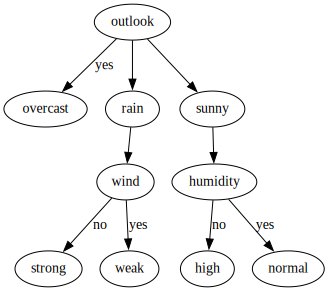

In [15]:
#Vẽ cây

def visualize_tree(tree):
    dot = graphviz.Digraph()

    def add_nodes(tree, parent=None):
        for node_name, subtree in tree.items():
            if isinstance(subtree, dict):
                if parent is not None:
                    dot.edge(str(parent), str(node_name))
                add_nodes(subtree, parent=node_name)
            else:
                dot.edge(str(parent), str(node_name), label=str(subtree))

    add_nodes(tree)
    return dot

visualize_tree(id3_tree)
